In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Mol
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdqueries

In [2]:
IPythonConsole.drawOptions.addAtomIndices = True
# IPythonConsole.drawOptions.addBondIndices = True

In [3]:
def run_rxn(rxn_sml, mol):
    rxn = AllChem.ReactionFromSmarts(rxn_sml)
    try:
        products = rxn.RunReactants((mol,))
    except IndexError:
        raise IndexError("Reaction failed; the starting material may not match the reaction SMARTS")
    return products

In [4]:
def plot_rxn(rxn_sml, mol):
    print("Reactant:")
    display(mol)
    try:
        products = run_rxn(rxn_sml, mol)
    except IndexError as e:
        print(e)
        return
    if not products:
        print("No products")
        return
    print("Distinct products:")
    product_smls = set()
    for product in products:
        product_mol = product[0]
        # Get the canonical SMILES string of the product molecule
        this_sml = Chem.MolToSmiles(product_mol)
        if this_sml in product_smls:
            continue
        product_smls.add(this_sml)
        print(Chem.MolToSmiles(product_mol))
        display(product_mol)
    return product_smls

## Katritzky salts, e.g. https://doi.org/10.1039/P19790000430

### Scheme 13A: Oxepinium -> pyridinium

For this first example, let's start by defining the SMARTS pattern for the starting material. It's an [azine, a six-membered aromatic ring with a hetero atom](https://en.wikipedia.org/wiki/Azine_(heterocycle)). The oxygen will be replaced with a nitrogen (connected to an R group), so let's provide an atom number for the oxygen. We'll visualize the SMARTS pattern as a molecule to check that it matches the starting material:

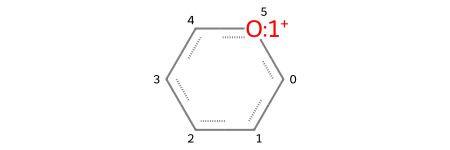

In [5]:
o_azine_smarts = "c1cccc[o+:1]1"
o_azine_smarts_mol = Chem.MolFromSmarts(o_azine_smarts)
o_azine_smarts_mol

Now we can use that reactant SMARTS and transform it to the product using [RDKit's Reaction SMARTS format](https://drzinph.com/learning-reaction-smarts-a-practical-guide-to-reaction-based-patterns/):
> [Reactants]>>[Products]

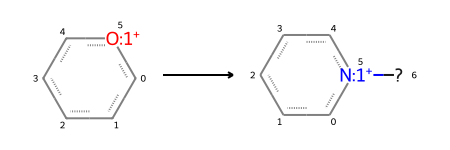

In [6]:
azine_o_to_n = f"{o_azine_smarts}>>c1cccc[n+:1]1-[R]"
azine_o_to_n_rxn = AllChem.ReactionFromSmarts(azine_o_to_n)
azine_o_to_n_rxn

Let's make sure that our starting material (represented with a Kekulé structure) matches the SMARTS pattern.

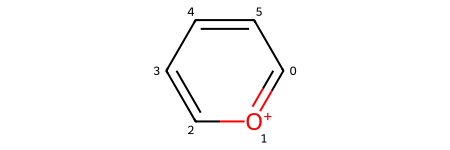

In [7]:
o_azine_sml = "C1=[O+]C=CC=C1"
o_azine = Chem.MolFromSmiles(o_azine_sml)
o_azine

In [8]:
o_azine.HasSubstructMatch(o_azine_smarts_mol)

True

But benzene shouldn't match the reactant SMARTS pattern because benzene lacks the oxygen in the aromatic ring:

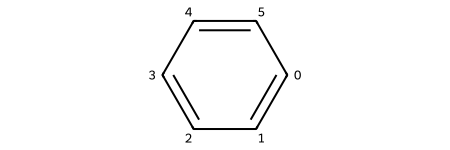

In [9]:
benzene_sml = "c1ccccc1"
benzene = Chem.MolFromSmiles(benzene_sml)
benzene

In [10]:
benzene.HasSubstructMatch(o_azine_smarts_mol)

False

Nor should tetrahydropyran because it's not aromatic and the oxygen atom doesn't have a positive charge:

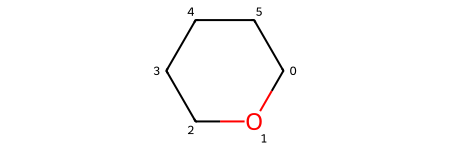

In [11]:
o_alicyclic_sml = "C1OCCCC1"
o_alicyclic = Chem.MolFromSmiles(o_alicyclic_sml)
o_alicyclic

In [12]:
o_alicyclic.HasSubstructMatch(o_azine_smarts_mol)

False

Nor should this eight-membered ring with alternating double and single bonds because it's anti-aromatic:

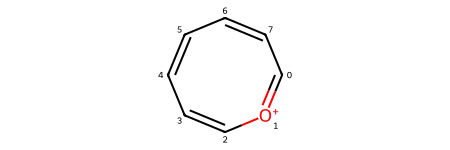

In [13]:
o_arene8_sml = "C1=[O+]C=CC=CC=C1"
o_arene8 = Chem.MolFromSmiles(o_arene8_sml)
o_arene8

In [14]:
o_arene8.HasSubstructMatch(o_azine_smarts_mol)

False

Reactant:


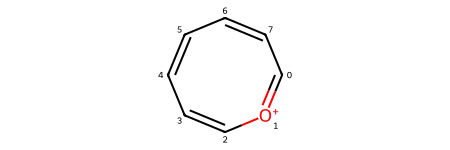

No products


In [15]:
o_arene10_sml = "C1=[O+]C=CC=CC=CC=C1"
o_arene10 = Chem.MolFromSmiles(o_arene10_sml)
o_arene10
product_smls = plot_rxn(azine_o_to_n, o_arene8)

In [16]:
o_arene10.HasSubstructMatch(o_azine_smarts_mol)

False

Here's the reaction from the SMARTS:

Reactant:


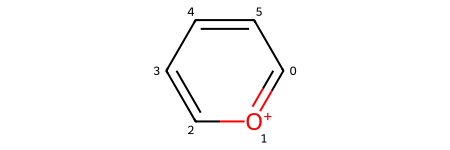

Distinct products:
*[n+]1ccccc1


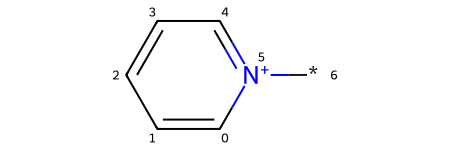

In [17]:
product_smls = plot_rxn(azine_o_to_n, o_azine)

In [18]:
product_smarts = product_smls.pop()

Reactant:


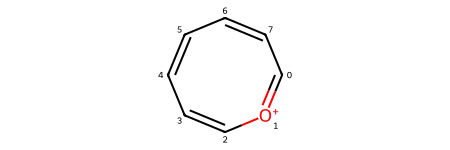

No products


In [19]:
product_smls = plot_rxn(azine_o_to_n, o_arene8)

In [20]:
run_rxn(azine_o_to_n, o_arene10)

()

#### Accomplish the same transformation using RDKit atom substitution

Because this is a fairly simple atom-for-atom replacement (though with the addition of an R group on the new atom), we can accomplish the same thing by modifying the molecule. We start by creating a read-write molecule from the original (read-only) molecule and verifying that it's the same as the original:

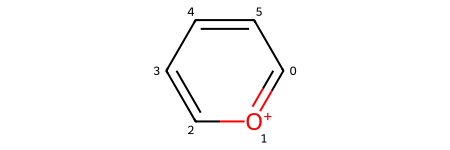

In [21]:
o_azine_rwm = Chem.RWMol(o_azine)
o_azine_rwm

To programmatically identify the oxygen atom by its atomic number of 8, we create and run a query.

In [22]:
hetero_atom_query = rdqueries.AtomNumEqualsQueryAtom(8)
hetero_atom = o_azine_rwm.GetAtomsMatchingQuery(hetero_atom_query)[0]
hetero_atom_idx = hetero_atom.GetIdx()
hetero_atom_idx

1

There's only one oxygen atom, so we can simply get the first atom matching the query. Now we'll replace the oxygen atom with a nitrogen:

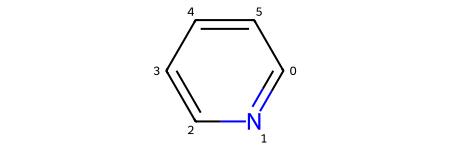

In [23]:
o_azine_rwm.ReplaceAtom(index = hetero_atom_idx, newAtom = Chem.Atom(7))
Chem.SanitizeMol(o_azine_rwm)
o_azine_rwm

To add the R group to the nitrogen, we use the read-write molecule's `AddAtom` method. We start by just adding the atom `*` representing the R group. If we leave it at that, the atom is disonnected from the rest of the molecule (note the `*` floating above the rest of the molecule):

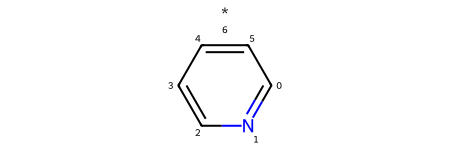

In [24]:
added_atom_idx = o_azine_rwm.AddAtom(Chem.Atom("*"))
o_azine_rwm

So we need to add a bond between the nitrogen and the R group. 

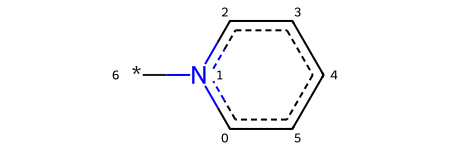

In [25]:
o_azine_rwm.AddBond(
    beginAtomIdx = hetero_atom_idx,
    endAtomIdx = added_atom_idx,
    order = Chem.BondType.SINGLE,
    )
o_azine_rwm

Now let's clean up the molecule by assigning the nitrogen to have no hydrogen atoms, and its charge to `+1`. First let's programmatically find the nitrogen atom. Not that its index is the same as the oxygen atom had, but we need to find the nitrogen atom (as an object) so we can adjust its properties later.

In [26]:
n_query = rdqueries.AtomNumEqualsQueryAtom(7)
n_at = o_azine_rwm.GetAtomsMatchingQuery(n_query)[0]
n_at.SetNoImplicit(True)
n_at.SetNumExplicitHs(0)
n_at.SetFormalCharge(1)

Next we'll draw the molecule, highlighting the substituted heteroatom, the new R group, and the bond between them.

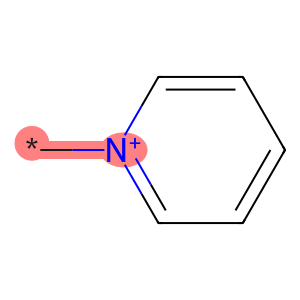

In [27]:
new_bond_idx = o_azine_rwm.GetBondBetweenAtoms(hetero_atom_idx, added_atom_idx).GetIdx()
Draw.MolToImage(
    mol = o_azine_rwm,
    highlightAtoms=[hetero_atom_idx, added_atom_idx],
    highlightBonds=[new_bond_idx],
    )

Finally, we'll convert the read-write molecule back to a read-only molecule, sanitize it, and display it.

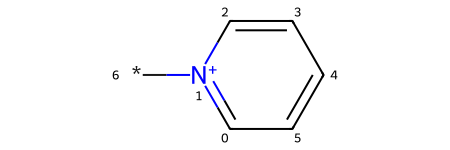

In [28]:
product = o_azine_rwm.GetMol()
Chem.SanitizeMol(product)
product

Let's check that the product is the same as that from the Reaction SMARTS.

In [29]:
product_smarts == Chem.MolToSmiles(product)

True

## Oliveira 2017 https://doi.org/10.1039/C7CS00184C

### Scheme 13C: Tetrazine -> Pyridazine

In [30]:
nn_aromatic_smarts = "n1nc(-[1*])[n:1][n:2]c(-[2*])1"
nn_aromatic_smarts_mol = Chem.MolFromSmarts(nn_aromatic_smarts)

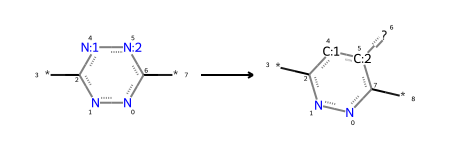

In [31]:
arene_nn_to_ccR = "[n]1nc(-*)[n:1][n:2]c(-*)1>>[n]1nc(-*)[c:1][c:2]([R])c(-*)1"

arene_nn_to_ccR_rxn = AllChem.ReactionFromSmarts(arene_nn_to_ccR)
arene_nn_to_ccR_rxn

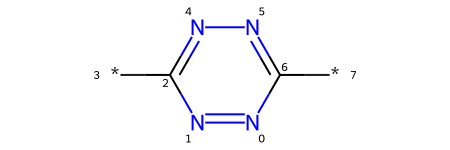

In [32]:
nn_sml = "n1nc(*)nnc(*)1"
nn = Chem.MolFromSmiles(nn_sml)
nn

In [33]:
# Check whether o_arene matches SMARTS pattern
nn_aromatic_smarts_mol.HasSubstructMatch(nn_aromatic_smarts_mol)

True

Reactant:


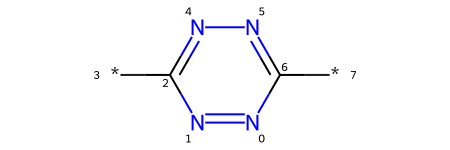

Distinct products:
*c1cc(*)c(*)nn1


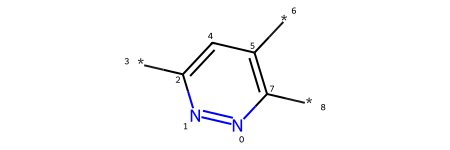

In [34]:
product_smls = plot_rxn(arene_nn_to_ccR, nn)

TODO: Make all the reactant SMARTS patterns for 13Di include the whole tricycle, not just SO2

## Yorimitsu 2016 https://pubs.acs.org/doi/10.1021/acs.orglett.5b03384

### Scheme 13Di left: Dibenzothiophene -> carbazole

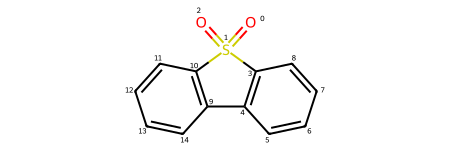

In [35]:
tricyclic_SO2 = "O=S1(=O)C2=C(C=CC=C2)C2=C1C=CC=C2"
tricyclic_SO2_mol = Chem.MolFromSmiles(tricyclic_SO2)
tricyclic_SO2_mol

In [36]:
tricyclic_SO2_N_Ph_R = "[O:1]=[S:2]=[0]>>[*][c]1[cH][cH][cH][cH][c:1]1[N:2]"
#TODO: Make R group at an undetermined position on phenyl ring

In [37]:
products_tricyclic_SO2_N_Ph_R = run_rxn(tricyclic_SO2_N_Ph_R, tricyclic_SO2_mol)

Reactant:


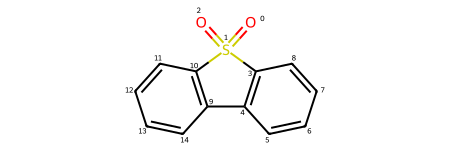

Distinct products:
*c1ccccc1N1c2ccccc2-c2ccccc21


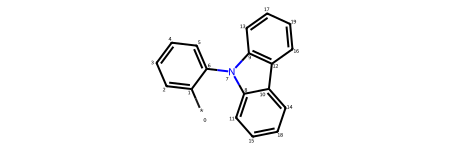

In [38]:
product_smls = plot_rxn(tricyclic_SO2_N_Ph_R, tricyclic_SO2_mol)

### Scheme 13Di bottom: Dibenzothiophene -> dibenzophosphole

In [39]:
# tricyclic_SO2_N_P_Ph_O = "[O:6]=[S:7]=[0]>>[c:1]1[cH:2][cH:3][cH:4][cH:5][c:6]1[P:7]=[O8]"
tricyclic_SO2_N_P_Ph_O = "[O]=[S:7]=[0]>>[c]1[cH][cH][cH][cH][c]1[P:7]=[O]"


Reactant:


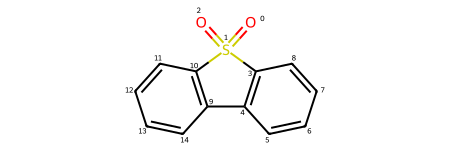

Distinct products:
O=P1(c2ccccc2)c2ccccc2-c2ccccc21


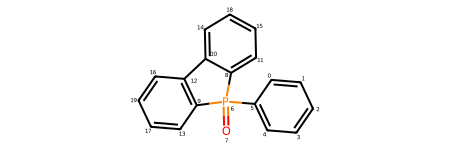

In [40]:
product_smls = plot_rxn(tricyclic_SO2_N_P_Ph_O, tricyclic_SO2_mol)

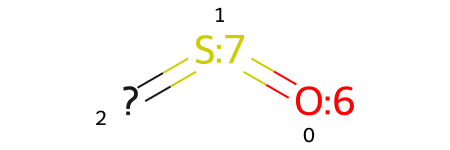

In [41]:
SO2_mol = Chem.MolFromSmarts("[O:6]=[S:7]=[0]")
SO2_mol

In [42]:
tricyclic_SO2_mol.HasSubstructMatch(SO2_mol)

True

### Scheme 13Di right: Dibenzothiophene -> Spirocyclic diarylfluorene

Reactant:


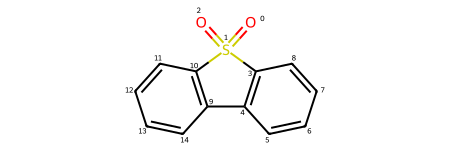

Distinct products:
*1C2=C(C=CC=C2)C2(C3=C1C=CC=c3)c1ccccc1-c1ccccc12


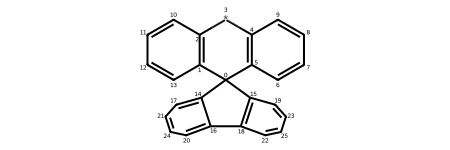

In [43]:
tricyclic_SO2_3ringsX = "[O]=[S:1]=[0]>>[C:1]1C2=C([X][C]3=[C]1[C]=[C][C]=[C]3)[C]=[C][C]=[c]2"
product_smls = plot_rxn(tricyclic_SO2_3ringsX, tricyclic_SO2_mol)

### Scheme 13Dii center: Dibenzothiophene -> Tribenzothiophene

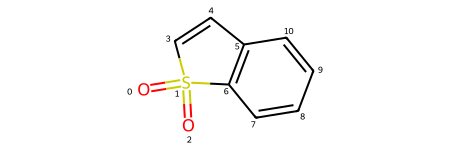

In [44]:
bicyclic_SO2 = "O=S1(=O)C=CC2=C1C=CC=C2"
bicyclic_SO2_mol = Chem.MolFromSmiles(bicyclic_SO2)
bicyclic_SO2_mol

Reactant:


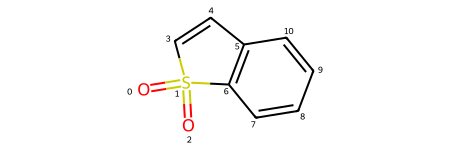

Distinct products:
O=S1(=O)C2=C(C=CC=C2)C2=C(C3=CC=CC=C3)C3=C(C=CC=C3)C(C3=CC=CC=C3)=C21


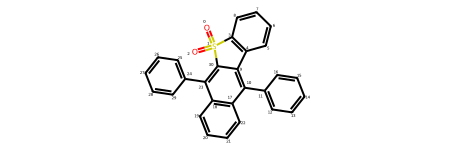

In [45]:
bicyclic_SO2_add_bicylic = "O=S1(=O)[C:1]=[C:2]c2c1cccc2>>O=S1(=O)C2=C(C=CC=C2)[C:1]2=C(C3=CC=CC=C3)C3=C(C=CC=C3)C(C3=CC=CC=C3)=[C:2]12"
product_smls = plot_rxn(bicyclic_SO2_add_bicylic, bicyclic_SO2_mol)

### Scheme 13Dii right: Tribenzothiophene -> Tribenzopyrrolidine

O=S1(=O)c2ccccc2-c2c1c(-c1ccccc1)c1ccccc1c2-c1ccccc1


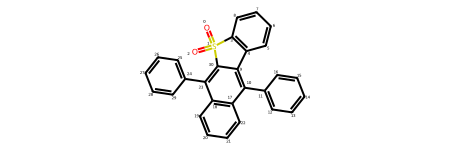

In [46]:
tetracyclic_SO2 = "O=S1(=O)C2=C(C=CC=C2)C2=C(C3=CC=CC=C3)C3=C(C=CC=C3)C(C3=CC=CC=C3)=C21"
tetracyclic_SO2_mol = Chem.MolFromSmiles(tetracyclic_SO2)
print(Chem.MolToSmiles(tetracyclic_SO2_mol))
tetracyclic_SO2_mol

Reactant:


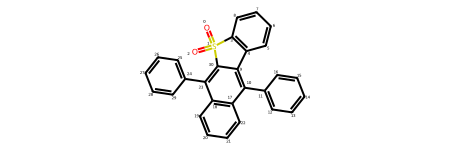

Distinct products:
Cc1ccc(N2c3ccccc3c3c2c(c2ccccc2)c2ccccc2c3c2ccccc2)cc1


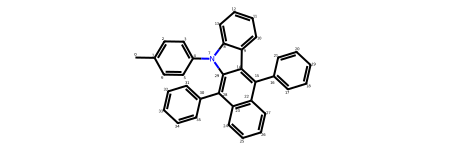

In [47]:
tetracyclic_SO2_N_p_tolyl = "O=[S:1]1(=O)c2ccccc2-c2c1c(-c1ccccc1)c1ccccc1c2-c1ccccc1>>C-c1ccc(cc1)[N:1]1c2c(cccc2)c2c(c3ccccc3)c3c(cccc3)c(c12)c1ccccc1"
product_smls = plot_rxn(tetracyclic_SO2_N_p_tolyl, tetracyclic_SO2_mol)

## Burns 2022 https://doi.org/10.1021/jacs.2c08464

### Scheme 14: Phenylazides to aminopyridines

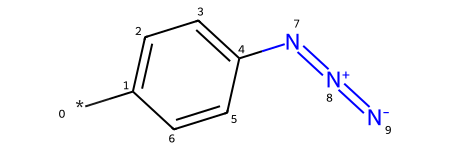

In [48]:
c_azide = "*c1ccc(cc1)N=[N+]=[N-]"
c_azide_mol = Chem.MolFromSmiles(c_azide)
c_azide_mol

Reactant:


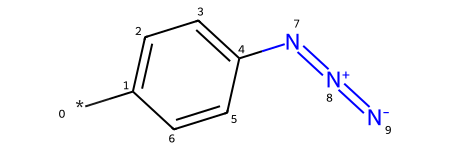

Distinct products:
*c1ccc(N([1*])[2*])nc1


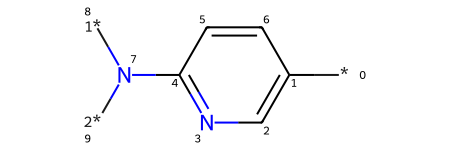

In [49]:
c_azide_n_c_NR2 = "*c1c[c:1]c(cc1)[N:2]=[N+]=[N-]>>*c1c[n:1]c(cc1)[N:2]([1*])[2*]"
product_smls = plot_rxn(c_azide_n_c_NR2, c_azide_mol)

## Morofuji & Kano 2021 https://doi.org/10.1021/acs.orglett.1c02225

### Scheme 15: Pyridines to anilines

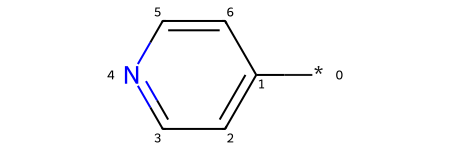

In [50]:
n = "*c1ccncc1"
n_mol = Chem.MolFromSmiles(n)
n_mol

Reactant:


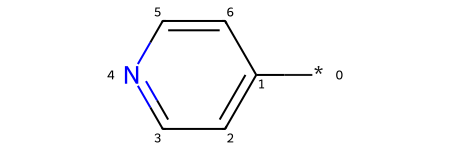

Distinct products:
*c1cccc(N([1*])[2*])c1


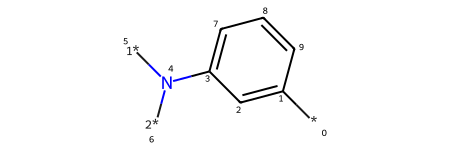

In [51]:
n_to_NR2 = "*c1c[c:2][n:1][c]c1>>*c1c[c:2](N([1*])([2*]))[c:1]cc1"
product_smls = plot_rxn(n_to_NR2, n_mol)

## Mindiola 2007 https://doi.org/10.1021/ja075326n

### Scheme 16: Pyridines to benzenoids

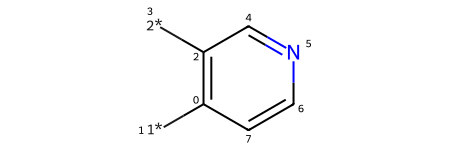

In [52]:
pyridine = "c1([1*])c([2*])cncc1"
pyridine_mol = Chem.MolFromSmiles(pyridine)
pyridine_mol

Reactant:


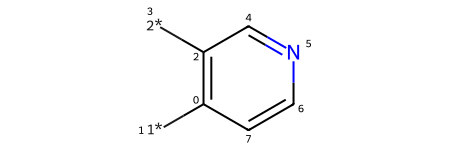

Distinct products:
[1*]c1ccc(C(C)(C)C)cc1[2*]


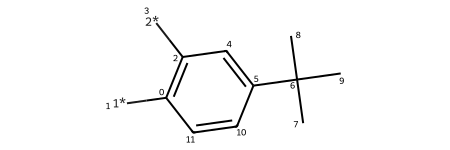

In [53]:
pyridine_to_benzenoid = "c1([1*])c([2*])c[n:1]cc1>>c1([1*])c([2*])c[c:1](C(C)(C)C)cc1"
product_smls = plot_rxn(pyridine_to_benzenoid, pyridine_mol)